# 05 - Advanced RavenPy configuration

In this notebook, we will explore alternative ways to setup a Raven model and run it using datasets from remote access points such as datasets hosted on the cloud.

## Running Raven using pre-existing configuration files

To run Raven, we need configuration (`.rvX`) files defining hydrological processes, watersheds and meteorological data. If you already have those configuration files ready, or want to see how to import an existing Raven model into PAVICS-Hydro, this tutorial is for you. It shows how to run Raven from a Python programming environment using [RavenPy](https://ravenpy.readthedocs.io/en/latest/). 

Let's start by importing some utilities that will make our life easier to get data on the servers. If you already have raven model setups, you could simply upload the files here and create your own "config" list:

In [1]:
from ravenpy.utilities.testdata import (  # Utility that simplifies getting data from a remote server hosted on the PAVICS-Hydro data server.
    get_file,
)

## A note on datasets

For this part of the tutorial, we will use pre-existing datasets that are hosted on the PAVICS-Hydro servers to setup the Raven model. This means that the .rv files are all built and the forcing file already exists. Let's import the files:

In [7]:
# Get the .rv files. It could also be the .rv files returned from the previous notebook, but here we are using a new basin that contains observed streamflow
# to make the calibration possible in the next notebook.
config = [
    get_file(f"raven-gr4j-cemaneige/raven-gr4j-salmon.{ext}")
    for ext in ["rvt", "rvc", "rvi", "rvh", "rvp"]
]
config

[PosixPath('/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/raven-gr4j-salmon.rvt'),
 PosixPath('/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/raven-gr4j-salmon.rvc'),
 PosixPath('/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/raven-gr4j-salmon.rvi'),
 PosixPath('/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/raven-gr4j-salmon.rvh'),
 PosixPath('/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/raven-gr4j-salmon.rvp')]

So "config" is just a set of paths to the various .rvX files (.rvt, .rvc, .rvi. .rvh and .rvp). Therefore, if you have your own .rv files that describe your model, you can upload them and replace "config" with your own files!


Now, we also need forcing data to run our model. Instead of using the ERA5 data from the previous notebooks, we will refer to our pre-existing files for this test watershed:

In [4]:
# Import the forcing data file that contains all the meteorological data as well as observed streamflow data.
forcing = get_file(
    "raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"
)
print(forcing)

/notebook_dir/writable-workspace/.home/.raven_testing_data/master/raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc


As expected, the "forcing" variable is nothing more than a path to the forcing data. Let's see what's inside!

In [5]:
import xarray as xr

ds = xr.open_dataset(forcing)
print(ds)

<xarray.Dataset>
Dimensions:       (nstations: 1, time: 20819)
Coordinates:
    station_name  (nstations) object ...
  * time          (time) datetime64[ns] 1954-01-01 1954-01-02 ... 2010-12-31
Dimensions without coordinates: nstations
Data variables:
    lon           (nstations) float64 ...
    lat           (nstations) float64 ...
    rain          (time) float64 ...
    snow          (time) float64 ...
    tmin          (time) float64 ...
    tmax          (time) float64 ...
    pet           (time) float64 ...
    qobs          (time) float64 ...
Attributes:
    description:  Merge Raven ASCII-formatted timeseries used in GR4J+CEMANEI...
    history:      Created by Juliane Mai 
    Conventions:  CF-1.6
    featureType:  timeSeries


This forcing dataset contains many more variables than what we had provided with ERA5. This is a good test basin to explore different Raven model configurations and options! Most notably, it contains:

- rain and snow: As individual variables, negating the need to separate total precipitation into liquid and solid components;
- pet: Pre-computed potential evapotranspiration, negating the need to compute it internally by Raven;
- qobs: streamflow observations, required for model calibration.

We can now try to run Raven with this existing configuration. We therefore **don't** have to provide:

- Start and end dates for the simulation (already included in the configuration files!)
- HRU information (already included in the configuration files!) 
- Parameters (already included in the configuration files!) 

## Building a hydrological model on-the-fly using existing configuration files.

Here we create a Raven model instance, configure it using the pre-defined configuration files and run it by providing the full path to the netCDF driving datasets. The configuration we provide is for a GR4J-CN model emulator that Raven will run for us. We provide the configuration files for GR4J-CN as well as the forcing data (precipitation, temperature, observed streamflow, etc.) that will be used to run the model.

In [6]:
# Import the Raven model object
from ravenpy.models import Raven

# Create an blank Raven model instance (general, not for a specific emulator)
model = Raven()

# Now configure it so that Raven emulates the model we want from our configuration files.
model.configure(config)

# Finally, call the model with the forcing data to run it. Later we will see how to also provide other options.
model(forcing, overwrite=True)

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge meteorological but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)


The model should have run! But you also might have noticed the two warnings that Raven is giving us:

- The first one is saying that we are providing rain and snow independently, but in the configuration files, we are asking the model to recompute the separation using an algorithm based on total precipitation and air temperature. This is OK, and we can live with this (alternatively, we could reconfigure the model to remove this but that will be for another notebook!).

- The second one is saying that we supply PET data, but the model is configured to compute PET from the available temperature and latitude/longitude data. This is also acceptable to us for now, so these warnings can be disregarded.


## Evaluating the model response

That's it! The code above has launched the GR4J model using weather data and the GR4J-CN configuration we provided. There are many other options we could provide, but for now we left everything to the default options to keep things simple. We will explore those in a future tutorial as well.
Now, let's look at the modeled hydrographs. Note that there is a "q_obs" hydrograph, representing the observations we provided ourselves. This is to facilitate the comparison between observations and simulations, and it is not required per se to run the model. The "q_sim" variable is the simulated streamflow and is the one we are interested in.

Note that RavenPy assumes that model outputs are always saved in netCDF format, and relies on [xarray](http://xarray.pydata.org/en/stable/) to access data. 

In [7]:
model.hydrograph

<xarray.Dataset>
Dimensions:     (time: 209, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 ... 1954-07-28
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Data variables:
    precip      (time) float64 ...
    q_sim       (time, nbasins) float64 ...
    q_obs       (time, nbasins) float64 ...
    q_in        (time, nbasins) float64 ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

We can visualize the simulated streamflow using xarray's built-in plotting tool, as follows:

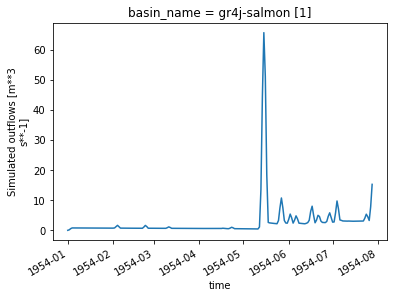

In [8]:
model.q_sim.plot()

Note that we could also extract much more data from the model, including state variables as in the previous notebook. However, we can now access a supplementary variable in the model outputs:

In [9]:
# Display model output choices
model.outputs

{'hydrograph': PosixPath('/tmp/tmpw2u_c2_t/exec/model/p00/output/Hydrographs.nc'),
 'storage': PosixPath('/tmp/tmpw2u_c2_t/exec/model/p00/output/WatershedStorage.nc'),
 'solution': PosixPath('/tmp/tmpw2u_c2_t/exec/model/p00/output/solution.rvc'),
 'diagnostics': PosixPath('/tmp/tmpw2u_c2_t/exec/model/p00/output/Diagnostics.csv'),
 'rv_config': PosixPath('/tmp/tmpw2u_c2_t/final/rv.zip')}

We can see that we now have access to diagnostics! This is because along with the simulated discharge, the model has access to observed discharge to compute error metrics such as RMSE and NSE. Let's see where the file has been generated:

In [10]:
print(model.outputs["diagnostics"])

/tmp/tmpw2u_c2_t/exec/model/p00/output/Diagnostics.csv


You can see that the path is a temporary one, because our configuration file did not specify a location where to save files. Therefore we will access only the contents of the diagnostics for now:

In [11]:
print("-----------------DIAGNOSTICS-----------------")
print(model.diagnostics)
print("")

-----------------DIAGNOSTICS-----------------
defaultdict(<class 'list'>, {'observed data series': ['HYDROGRAPH_ALL'], 'filename': ['Salmon-River-Near-Prince-George_meteo_daily.nc'], 'DIAG_NASH_SUTCLIFFE': [-0.314444], 'DIAG_RMSE': [59.4022]})



We can see that the Nash-Sutcliffe value is quite poor. This is due to the short simulation period in the configuration (see the hydrograph above!) and the lack of a spin-up period, combined to a poor parameter set choice. We will improve upon all of these shortcomings in the next notebook!

## Advanced RavenPy configuration options

Raven can perform many operations and has multiple configuration options. Here we provide a list of configuration options to explore which you can eventually use to taylor the codes to your own specifications.

We will give an overview of the various configuration keywords after this code block, but users should read the Raven documentation for more options for each of these processes.


In [12]:
import datetime as dt

# Import the list of possible model templates.
from ravenpy.models import GR4JCN

# Generate a GR4JCN-configured Raven model instance.
model = GR4JCN(workdir="/notebook_dir/writable-workspace/run_results")

# Generate a list of forcing data files.
forcing = ("ERA5_tmax.nc", "ERA5_tmin.nc", "ERA5_pr.nc")

# Get start and end dates
start_date = dt.datetime(1985, 1, 1)
end_date = dt.datetime(1990, 1, 1)

# Set parameters
params = (3.9, 1.396, 200.29, 10.072, 16.9, 0.947)


# Define the hydrological response unit.
hru = GR4JCN.LandHRU(
    area=4250.6, elevation=843.0, latitude=54.4848, longitude=-123.3659
)

# Run the model by passing the configuration variables we just established.
model(
    ts=forcing,
    start_date=start_date,
    end_date=end_date,
    hrus=(
        hru,
    ),  # Careful how this must be passed! This is due to the capability of running in distributed mode as well.
    params=params,
    run_name="test_basin",  # OPTIONAL: You can give your run a specific name to identify the results more easily. Files will contain the run_name as a prefix.
    overwrite=True,  # OPTIONAL: We can do this to overwrite old files with the new ones generated in this run (output files, etc.)
    # NEW CONFIG OPTIONS
    tasmax={
        "scale": 0.0,
        "offset": 1.0,
    },  # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=1.0 and b = -273.15 to bring K to degC.
    tasmin={
        "scale": 0.0,
        "offset": 1.0,
    },  # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=1.0 and b = -273.15 to bring K to degC.
    pr={
        "scale": 1.1
    },  # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=86400 and b = 0 to bring mm/s to mm/d.
    rain_snow_fraction="RAINSNOW_DINGMAN",
    evaporation="PET_OUDIN",
    ow_evaporation="PET_OUDIN",
    nc_index=0,  # Index of the catchment if your NetCDF has multiple basins.
    suppress_output=True,
)

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)


We can see that we have added some configuration keywords in the above code block when calling the model. Here is an overview of what each configuration variable represents:

- tasmax, tasmin, pr: For each input variable, we can add a multiplier or an additive constant (or both!) to convert units on the fly. The syntax is:
    tasmin={"scale":VALUE, "offset":VALUE}. The scale is a multiplicative value and the offset is the additive value. They are applied using the equation **Y=scale\ * X + offset**, so if scale is set  to 1 and the offset is set to 0, there will be no change. This can be useful to convert Kelvin temperatures to degrees Celsius ("offset" = -273.15) or meters of precipitation to millimeters ("scale" = 1000). In this case, we are using data already in °C and in mm, so we don't actually want to apply large changes. But just to show the capabilities, we applied a small 1°C offset and a 1.1 scaling factor for precipitaion (i.e. adding 10%).
    
- rain_snow_fraction: Algorithm to use to separate the total precipitation into rainfall and snowfall. See Raven documentation for more options.
- evaporation: Formula to use to compute the evapotranspiration from the land HRUs.
- ow_evaporation: Formula to use to compute the open-water evapotranspiration from the lake HRUs.
- nc_index: If you have a netcdf file that contains data for multiple catchments, you can use this indicator to tell Raven which of the basins you wish to run. In this case, we only have one basin, so the basin position is the 0th in Python.
- suppress_output: Boolean that indicates if you wish for Raven to provide information after the model evaluation by writing to file. For a single run this can be left to **False**, but for calibration and other intensive tasks, it is faster to leave it to **True**.
